# Introduction
This notebook contains example workflow for web services exposed by the EIDA (European Integrated Data Archive) Federation, focused on the EIDAWS-WFCatalog service and its functionalities allowing users to filter out low quality and low coverage data before downloading it to the local machine.

In this example we are going to:
1. Retrieve seismic event information from FDSNWS-Event catalogue offered by [GFZ](https://www.gfz-potsdam.de/) EIDA Node.
1. List all stations available in proximity to given event using [EIDAWS-Federator](http://eida-federator.ethz.ch/) web service.
1. Using EIDAWS-WFCatalog service, we are going to exclude all stations which do not meet following criteria:
    - At least 95% data coverage on the day of the event
    - Maximum of 5 gaps
    - Sum of gaps lower than 50 seconds
    - No overlaps
1. Using FDSNWS-Federator web service, we are going to download:
    - miniSEED file containing the waveforms
    - StationXML file containing station and instrumentation metadata on channel level

# 1. Finding event
Lets start by finding an event. Below two completely different approaches have been presented:
- Downloading event XML document directly from FDSNWS-Event web service
- Downloading event information using ObsPy library


In [2]:
import requests
import xml.etree.ElementTree as ET

ENCODING = "utf-8"
NSMAP = {'mw': 'http://quakeml.org/xmlns/bed/1.2'}

# Define start and end dates
start = "2020-01-01"
end = "2020-06-01"

# Define the bounding box
min_mag = 5
min_lat = 40
max_lat = 45
min_lon = 17
max_lon = 25

events_url = (
    f"http://geofon.gfz-potsdam.de/fdsnws/event/1/query?"
    f"start={start}&end={end}&"
    f"minmag={min_mag}&"
    f"minlat={min_lat}&minlon={min_lon}&"
    f"maxlat={max_lat}&maxlon={max_lon}"
)

# http://geofon.gfz-potsdam.de/fdsnws/event/1/query?start=2020-01-01&end=2020-06-01&minmag=5&minlat=40&minlon=17&maxlat=45&maxlon=25

r = requests.get(events_url, timeout=10)
r.encoding = ENCODING

if r.status_code == 200:
    event_root = ET.fromstring(r.text)
    for event_element in event_root.findall("./mw:eventParameters/*", namespaces=NSMAP):
        # Get event ID from event_element attribute
        event_id = event_element.get("publicID")
        
        # Find event magnitude element
        event_magnitude_element = event_element.find("./mw:magnitude/mw:mag/mw:value", namespaces=NSMAP)
        
        # Get magnitude value from event_magnitude_element
        event_magnitude = event_magnitude_element.text
        
        # Get event origin time element
        event_origin_time_element = event_element.find("./mw:origin/mw:time/mw:value", namespaces=NSMAP)
        
        # Get origin time value from event_origin_time_element
        event_origin_time = event_origin_time_element.text
        
        print(f"Event with ID: {event_id} happened on {event_origin_time} and had magnitude equal to: {event_magnitude}")
else:
    print("Something went wrong...")

Event with ID: smi:org.gfz-potsdam.de/geofon/gfz2020bywr happened on 2020-01-28T20:15:10.670309Z and had magnitude equal to: 5.062193141


And now with ObsPy...

In [3]:
from obspy import read_events

# Read events using the same URL
evts = read_events(events_url)

# Print retrieved events
for e in evts:
    print(e)

Event:	2020-01-28T20:15:10.670309Z | +41.433,  +19.569 | 5.062193141 M  | automatic

	            resource_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/gfz2020bywr")
	          creation_info: CreationInfo(agency_id='GFZ', creation_time=UTCDateTime(2020, 1, 28, 20, 16, 31, 618036))
	    preferred_origin_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953/netMag/M")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


Users are free to choose how they download data from EIDA, but for convenience we will continue using ObsPy throughout the rest of this notebook. 🦥

# 2. Finding stations

In [4]:
# from obspy import read_inventory
from obspy.clients.fdsn import RoutingClient
from obspy import UTCDateTime

# Build URL using EIDA Federator and our defined parameters
# stations_url = (
#     f"http://eida-federator.ethz.ch/fdsnws/station/1/query?"
#     f"start={start}&end={end}&"
#     f"minlat={min_lat}&minlon={min_lon}&"
#     f"maxlat={max_lat}&maxlon={max_lon}"
# )

# inv = read_inventory(stations_url)

# Read station metadata
client = RoutingClient("eida-routing")

st = UTCDateTime(start)
et = UTCDateTime(end)

inv = client.get_stations(
    starttime=st,
    endtime=et,
    minlatitude=min_lat,
    maxlatitude=max_lat,
    minlongitude=min_lon,
    maxlongitude=max_lon
)

print(inv)

Inventory created at 2020-11-26T09:23:36.397158Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: ObsPy FDSN Routing 1.2.2,SeisComP,SeisComP3,SeisNet-mysql (GFZ,INGV-CNT,NIEP,NOA,ODC)
	Contains:
		Networks (13):
			AC, BS, CR, EG, HI, HL, HT, IV, ME, MN, OT, RO, SJ
		Stations (68):
			AC.BCI (Bajram Curri)
			AC.KBN (Korce)
			AC.LSK (Leskovik)
			AC.PHP (Peshkopi)
			AC.PUK (Puke, Albania)
			AC.VLO (Vlore, Albania)
			BS.BLKB (Belogradchik)
			BS.KOZAM (Kozlodui)
			BS.MALO (Malo)
			BS.MNNAM (Montana)
			BS.PLVAM (Vidin)
			BS.PLVB (Pleven)
			CR.DBRK (Dubrovnik, Croatia)
			CR.MAKA (Makarska, Croatia)
			CR.RIC (Ricice, Croatia)
			EG.MMAA (Museum_Macedonian_Struggle,Thessaloniki,Greece)
			EG.SHTA (Scholi_Tiflon,Thessaloniki,Greece)
			EG.STC (Stivos Community Building)
			EG.STE (Stivos_Church,EUROSEISTEST,Greece)
			HI.DRA2 (Hospital,Drama,Eastern Macedonia)
			HI.LMS2 (TownHall,Laimos,Florina,Western Macedonia)
			HI.THS1 (HealthCenter,Prinos,Thasos Is

# 3. Filter stations which do not meet our quality criteria
We want to download data from stations which have:
1. At least 95% data coverage on the day of the event
1. Maximum of 5 gaps
1. Sum of gaps lower than 50 seconds
1. No overlaps

In [4]:
import json
from datetime import datetime, timedelta

# Convert string representation of origin time to datetime object
dt_origin = datetime.strptime(event_origin_time, "%Y-%m-%dT%H:%M:%S.%fZ")

# Define relative time windows using event origin time
dt_start = dt_origin - timedelta(minutes=5)
dt_end = dt_origin + timedelta(minutes=15)

# https://federator.orfeus-eu.org/eidaws/wfcatalog/1/query?starttime=2020-01-28T20:14:10.670309&endtime=2020-01-28T20:16:10.670309&network=HL&station=KZN

# List of verified stations, will be filled later
verified_stations = []

# Our validating function
def validate_station(string):
    # Parse string to json object
    j = json.loads(string)

    for cha in j:
        # Get network station channel identifiers
        network_code = cha["network"]
        station_code = cha["station"]
        channel_code = cha["channel"]
        
        # Get the quality metrics
        availability = float(cha["percent_availability"])
        gaps = float(cha["num_gaps"])
        sum_gaps = float(cha["sum_gaps"])
        overlaps = float(cha["num_overlaps"])
        
        print(f"Validating {network_code}.{station_code}.{channel_code}:")
        print(f"Availability: {availability}, gaps: {gaps}|{sum_gaps} overlaps: {overlaps}.")
        
        if availability < 95 or gaps > 5 or sum_gaps > 50 or overlaps > 0:
            print("Station does not meet criteria.\n")
            return False

    # Everything looks fine
    print("Station OK.\n")
    return True

# Loop through all networks and stations found in the bounding box surrounding our event
for net in inv:
    for sta in net:
        # Build WFCatalog URL (POST method is not avaiable via Federator)
        wfcatalog_url = (
            f"http://eida-federator.ethz.ch/eidaws/wfcatalog/1/query?"
            f"start={dt_start.isoformat()}&end={dt_end.isoformat()}&"
            f"network={net.code}&station={sta.code}"
        )

        # Request the data...
        r = requests.get(wfcatalog_url, timeout=10)
        r.encoding = ENCODING
        
        if r.status_code == 200:
            # Validate station
            if validate_station(r.text):
                # Validation passed, add to verified_stations list
                verified_stations.append([net.code, sta.code])
        else:
            # print(f"No data for {net.code}.{sta.code}")
            pass

print("The verified stations are:", verified_stations)



Validating SJ.BBLS.BHE:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 2.0.
Station does not meet criteria.

Validating SJ.BEO.BHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating SJ.BEO.BHE:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating SJ.BEO.BHN:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Station OK.

Validating SJ.DJES.BHE:
Availability: 99.99716435185185, gaps: 1.0|2.45 overlaps: 681.0.
Station does not meet criteria.

Validating IS.MMB1.BHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Station OK.

Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating MT.THE.DHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Station OK.

V

Validating HT.THE.HHE:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating HT.THE.HHZ:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Validating HT.THE.HHN:
Availability: 100.0, gaps: 0.0|0.0 overlaps: 0.0.
Station OK.

The verified stations are: [['SJ', 'BEO'], ['IS', 'MMB1'], ['MT', 'THE'], ['MN', 'BLY'], ['MN', 'PDG'], ['OT', 'TAR1'], ['EG', 'MMAA'], ['EG', 'SHTA'], ['EG', 'STC'], ['EG', 'STE'], ['HL', 'KZN'], ['HL', 'PENT'], ['HL', 'PLG'], ['HT', 'GRG'], ['HT', 'KNT'], ['HT', 'LIT'], ['HT', 'NEST'], ['HT', 'OUR'], ['HT', 'SOH'], ['HT', 'THAS'], ['HT', 'THE']]


# 4. Download data for verified stations

3 Trace(s) in Stream:
SJ.BEO..BHZ | 2020-01-28T20:10:01.805000Z - 2020-01-28T20:30:11.855000Z | 20.0 Hz, 24202 samples
SJ.BEO..BHE | 2020-01-28T20:10:07.085000Z - 2020-01-28T20:30:14.235000Z | 20.0 Hz, 24144 samples
SJ.BEO..BHN | 2020-01-28T20:10:05.575000Z - 2020-01-28T20:30:14.425000Z | 20.0 Hz, 24178 samples


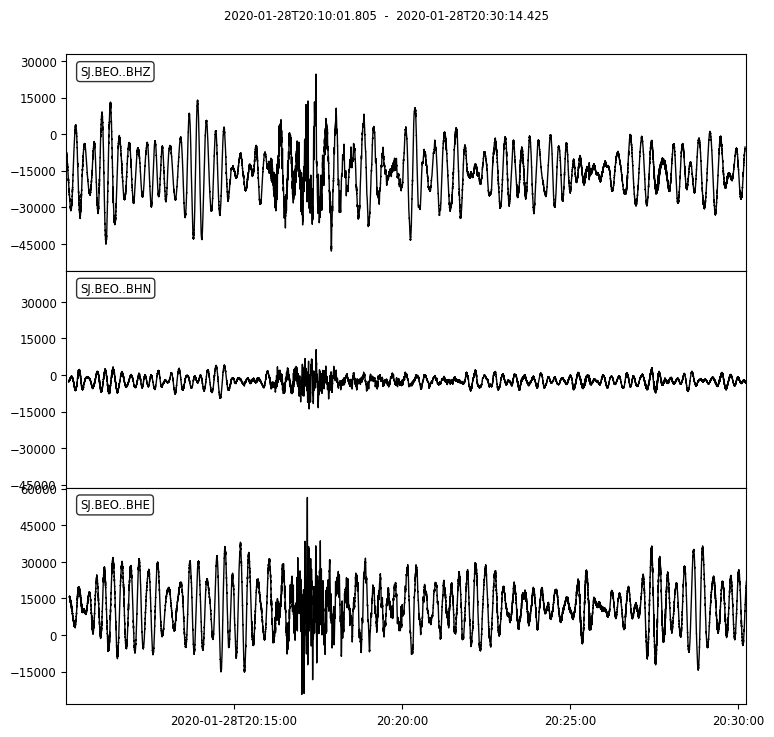

1 Trace(s) in Stream:
IS.MMB1..BHZ | 2020-01-28T20:10:08.750000Z - 2020-01-28T20:30:13.275000Z | 40.0 Hz, 48182 samples


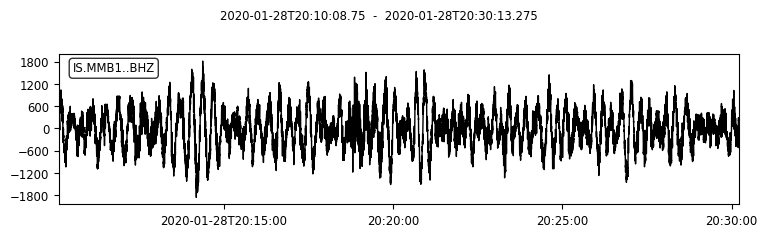

6 Trace(s) in Stream:
MT.THE.01.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples
MT.THE.02.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples
MT.THE.03.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples
MT.THE.05.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples
MT.THE.00.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples
MT.THE.04.DHZ | 2020-01-28T20:10:10.000000Z - 2020-01-28T20:30:10.000000Z | 250.0 Hz, 300001 samples


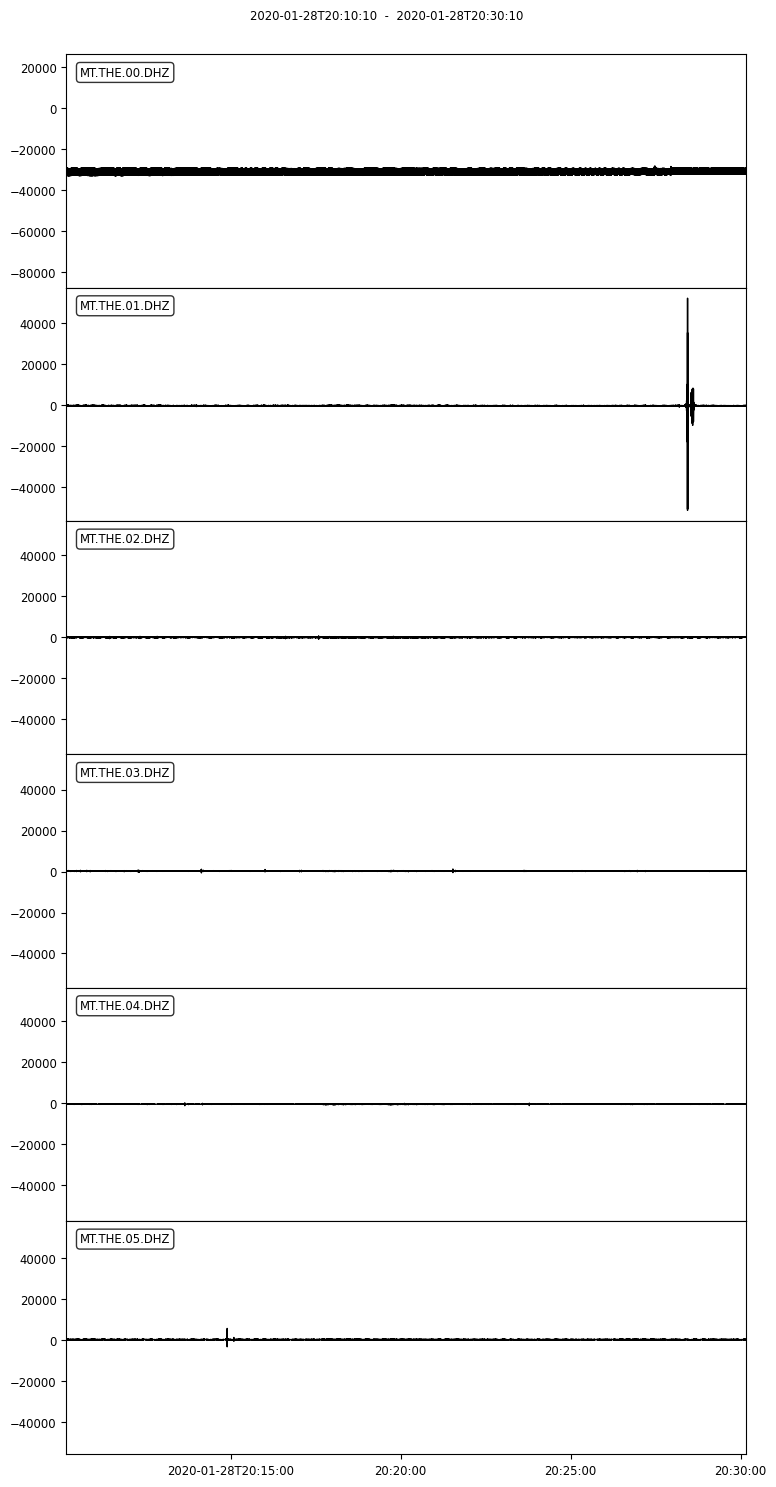

12 Trace(s) in Stream:
MN.BLY..BHE | 2020-01-28T20:10:01.419538Z - 2020-01-28T20:30:13.369538Z | 20.0 Hz, 24240 samples
MN.BLY..BHN | 2020-01-28T20:10:05.419538Z - 2020-01-28T20:30:12.369538Z | 20.0 Hz, 24140 samples
MN.BLY..BHZ | 2020-01-28T20:10:08.419538Z - 2020-01-28T20:30:24.369538Z | 20.0 Hz, 24320 samples
MN.BLY..HHE | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120600 samples
MN.BLY..HHN | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:12.958392Z | 100.0 Hz, 120500 samples
MN.BLY..HNE | 2020-01-28T20:10:08.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120500 samples
MN.BLY..HHZ | 2020-01-28T20:10:09.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120400 samples
MN.BLY..HNN | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120600 samples
MN.BLY..LHE | 2020-01-28T20:08:33.069537Z - 2020-01-28T20:30:51.069537Z | 1.0 Hz, 1339 samples
MN.BLY..HNZ | 2020-01-28T20:10:05.968392Z - 2020-01-28T20:30:11.958392Z | 100.0 Hz, 120600 sampl

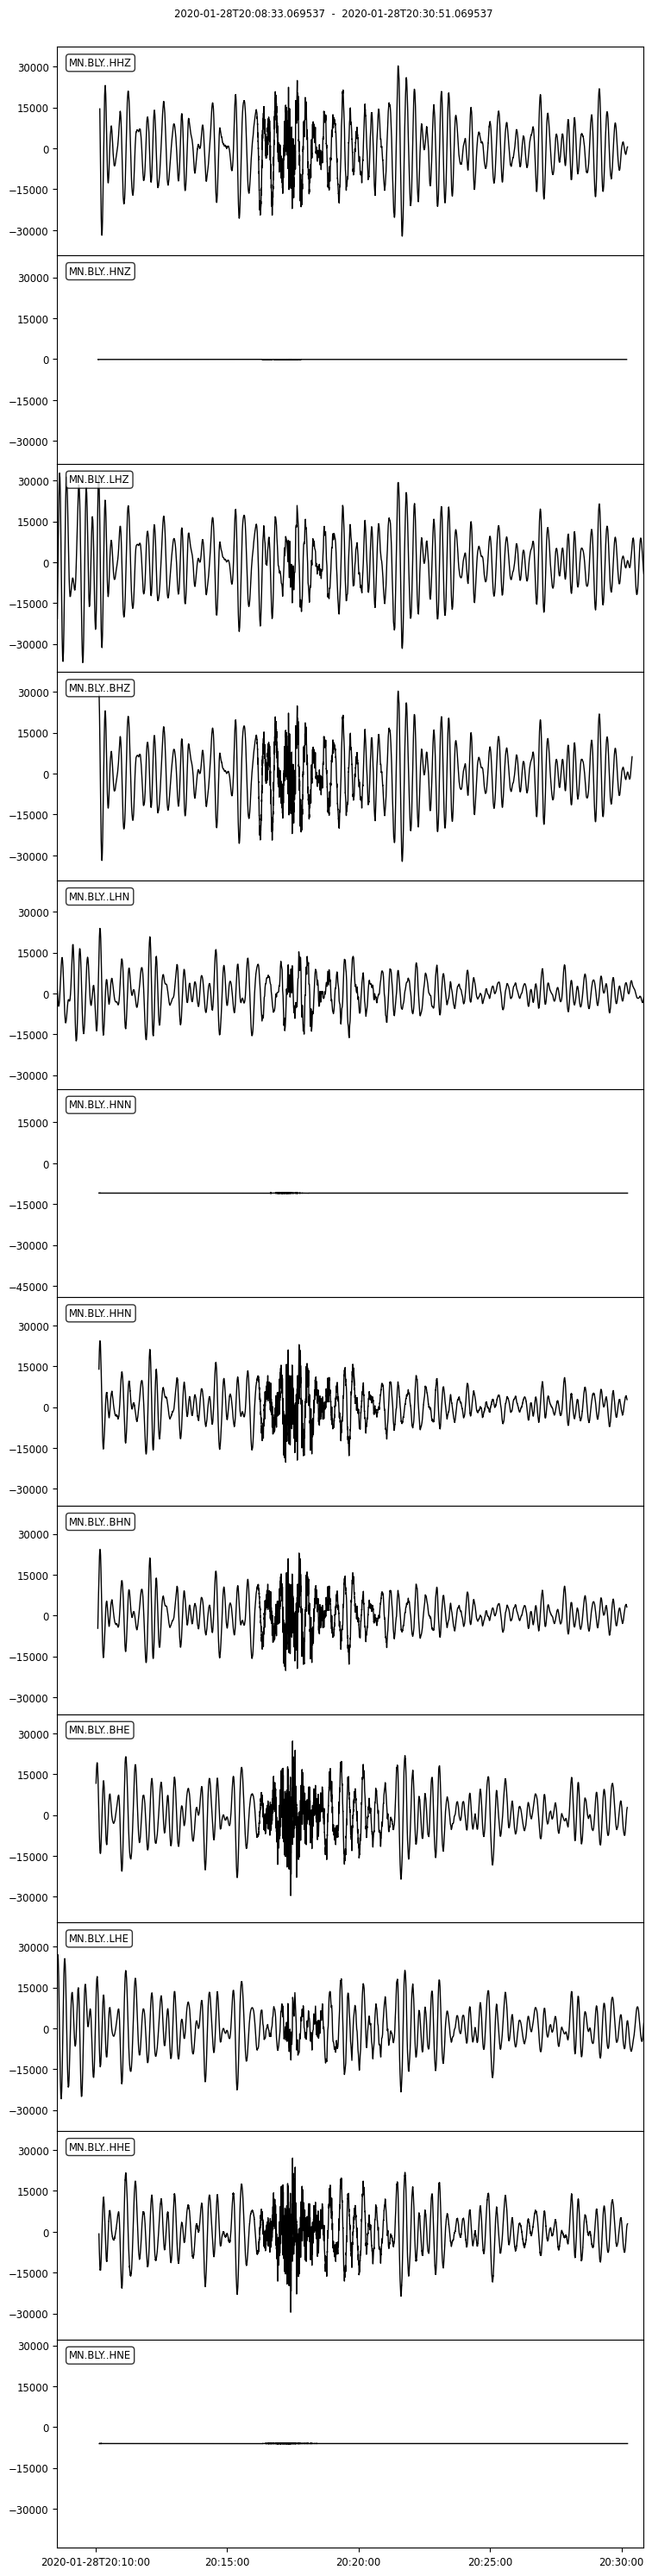

12 Trace(s) in Stream:
MN.PDG..BHE | 2020-01-28T20:10:04.419538Z - 2020-01-28T20:30:14.369538Z | 20.0 Hz, 24200 samples
MN.PDG..BHN | 2020-01-28T20:09:55.419538Z - 2020-01-28T20:30:23.369538Z | 20.0 Hz, 24560 samples
MN.PDG..BHZ | 2020-01-28T20:10:06.419538Z - 2020-01-28T20:30:22.369538Z | 20.0 Hz, 24320 samples
MN.PDG..HHE | 2020-01-28T20:10:09.968392Z - 2020-01-28T20:30:14.958392Z | 100.0 Hz, 120500 samples
MN.PDG..HHN | 2020-01-28T20:10:09.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120400 samples
MN.PDG..HHZ | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:14.958392Z | 100.0 Hz, 120700 samples
MN.PDG..HNE | 2020-01-28T20:10:08.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120500 samples
MN.PDG..HNN | 2020-01-28T20:10:06.968392Z - 2020-01-28T20:30:15.958392Z | 100.0 Hz, 120900 samples
MN.PDG..LHE | 2020-01-28T20:09:54.069537Z - 2020-01-28T20:30:29.069537Z | 1.0 Hz, 1236 samples
MN.PDG..HNZ | 2020-01-28T20:10:09.968392Z - 2020-01-28T20:30:15.958392Z | 100.0 Hz, 120600 sampl

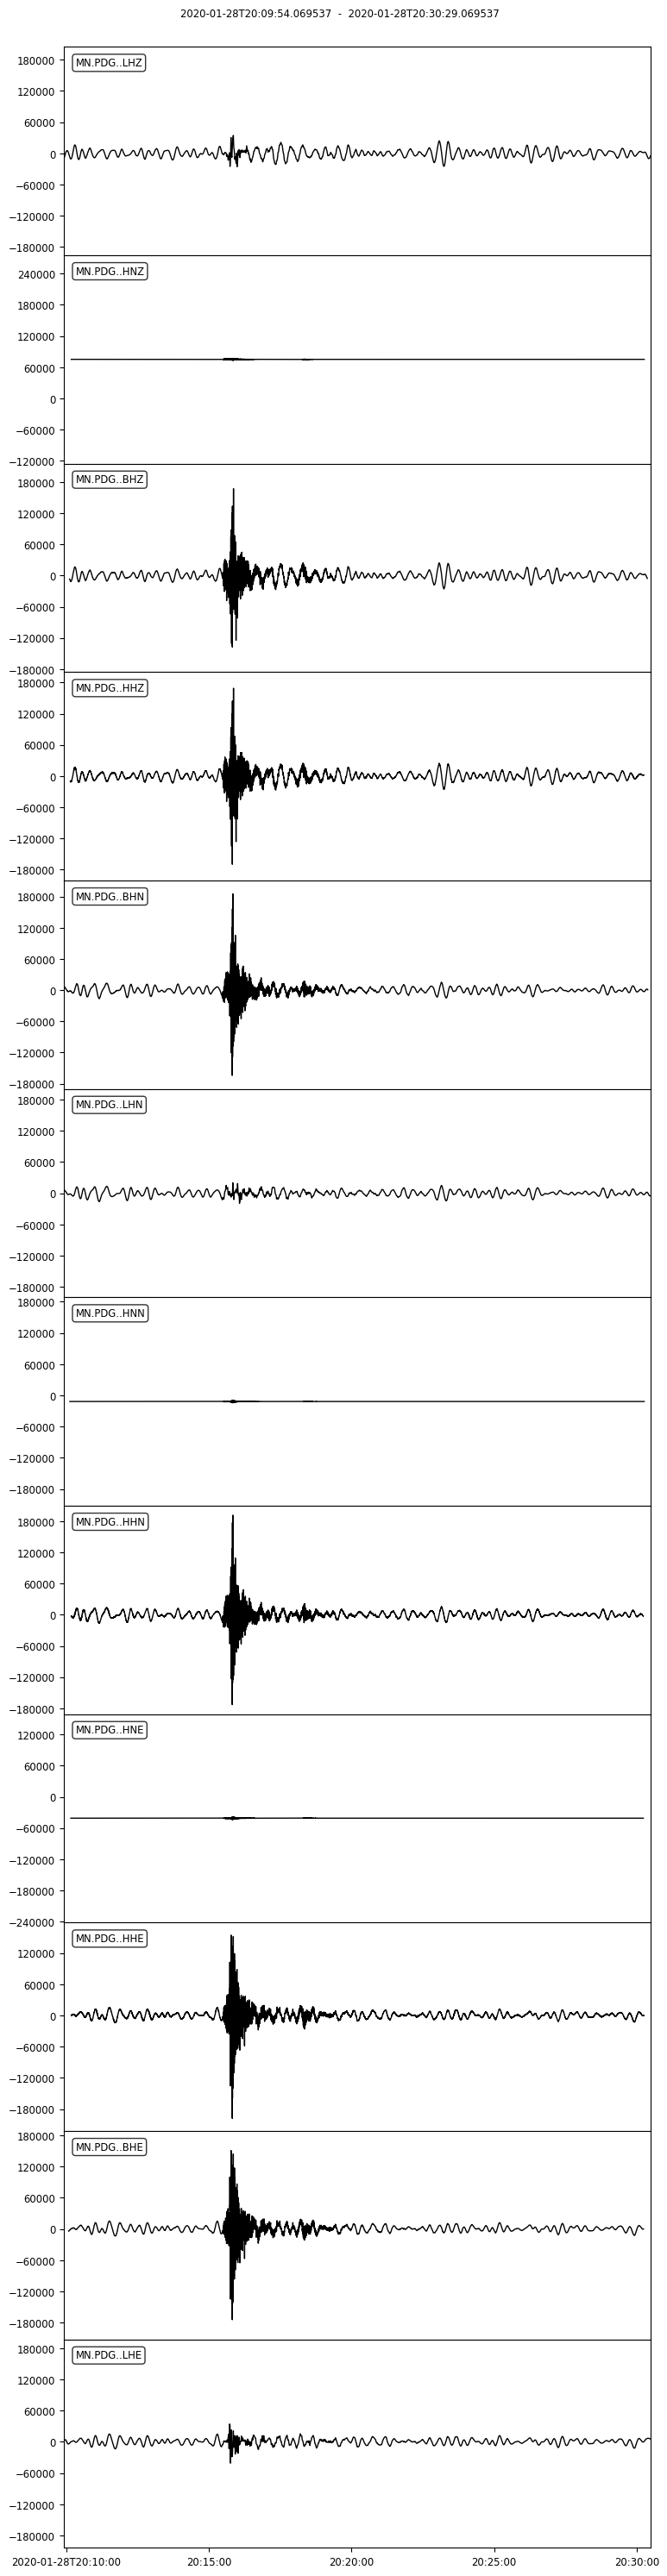

3 Trace(s) in Stream:
OT.TAR1..HHE | 2020-01-28T20:10:10.490000Z - 2020-01-28T20:30:13.770000Z | 100.0 Hz, 120329 samples
OT.TAR1..HHN | 2020-01-28T20:10:09.780000Z - 2020-01-28T20:30:11.800000Z | 100.0 Hz, 120203 samples
OT.TAR1..HHZ | 2020-01-28T20:10:10.220000Z - 2020-01-28T20:30:11.350000Z | 100.0 Hz, 120114 samples


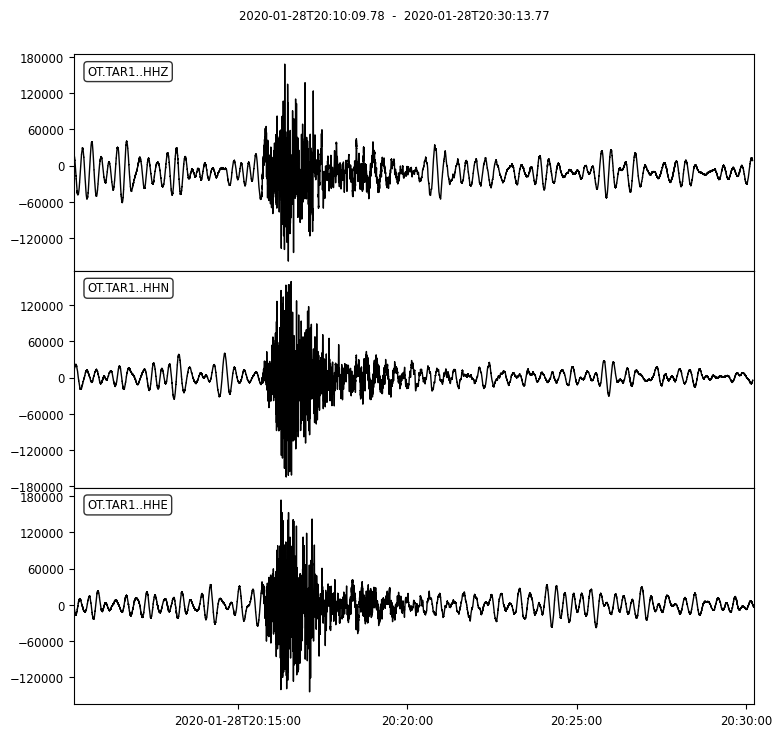

3 Trace(s) in Stream:
EG.MMAA..EN2 | 2020-01-28T20:10:09.785000Z - 2020-01-28T20:30:11.085000Z | 200.0 Hz, 240261 samples
EG.MMAA..EN3 | 2020-01-28T20:10:09.390000Z - 2020-01-28T20:30:11.595000Z | 200.0 Hz, 240442 samples
EG.MMAA..EN1 | 2020-01-28T20:10:09.990000Z - 2020-01-28T20:30:11.180000Z | 200.0 Hz, 240239 samples


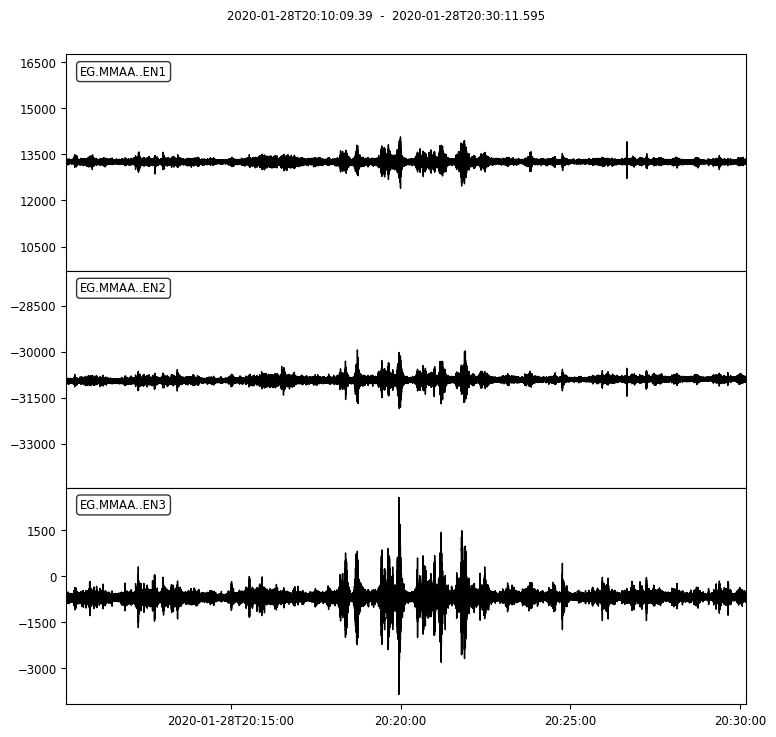

3 Trace(s) in Stream:
EG.SHTA..EN1 | 2020-01-28T20:10:09.145000Z - 2020-01-28T20:30:11.655000Z | 200.0 Hz, 240503 samples
EG.SHTA..EN3 | 2020-01-28T20:10:09.790000Z - 2020-01-28T20:30:11.735000Z | 200.0 Hz, 240390 samples
EG.SHTA..EN2 | 2020-01-28T20:10:09.880000Z - 2020-01-28T20:30:10.850000Z | 200.0 Hz, 240195 samples


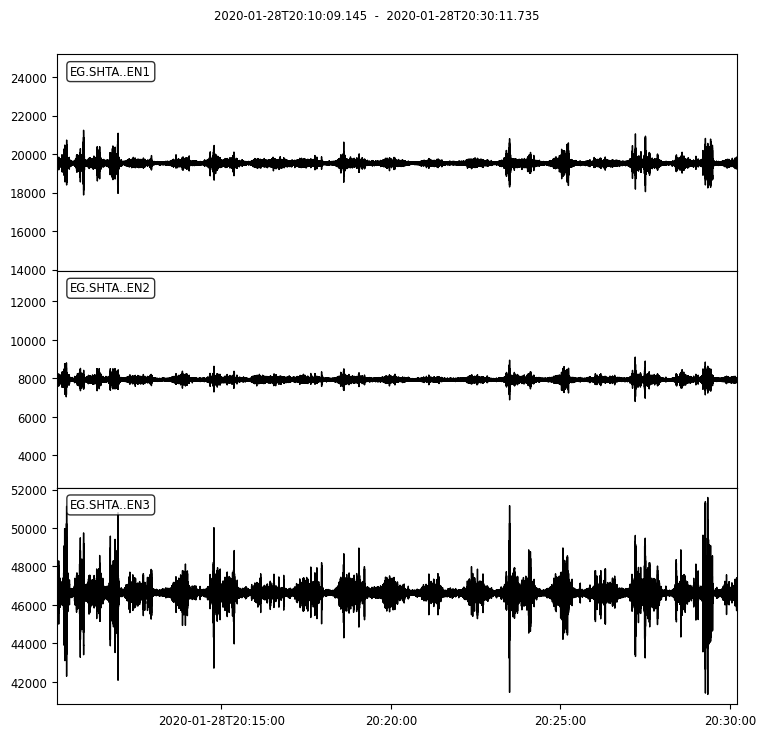

3 Trace(s) in Stream:
EG.STC..EN2 | 2020-01-28T20:10:10.300000Z - 2020-01-28T20:30:13.070000Z | 200.0 Hz, 240555 samples
EG.STC..EN1 | 2020-01-28T20:10:10.290000Z - 2020-01-28T20:30:11.235000Z | 200.0 Hz, 240190 samples
EG.STC..EN3 | 2020-01-28T20:10:10.460000Z - 2020-01-28T20:30:11.965000Z | 200.0 Hz, 240302 samples


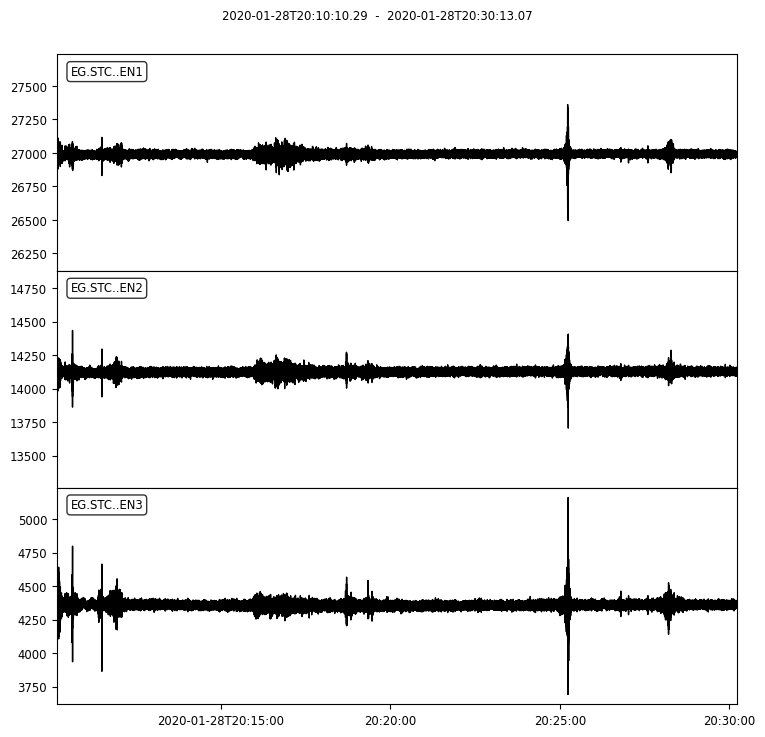

3 Trace(s) in Stream:
EG.STE..EN2 | 2020-01-28T20:10:10.345000Z - 2020-01-28T20:30:10.815000Z | 200.0 Hz, 240095 samples
EG.STE..EN3 | 2020-01-28T20:10:10.540000Z - 2020-01-28T20:30:11.390000Z | 200.0 Hz, 240171 samples
EG.STE..EN1 | 2020-01-28T20:10:09.320000Z - 2020-01-28T20:30:12.460000Z | 200.0 Hz, 240629 samples


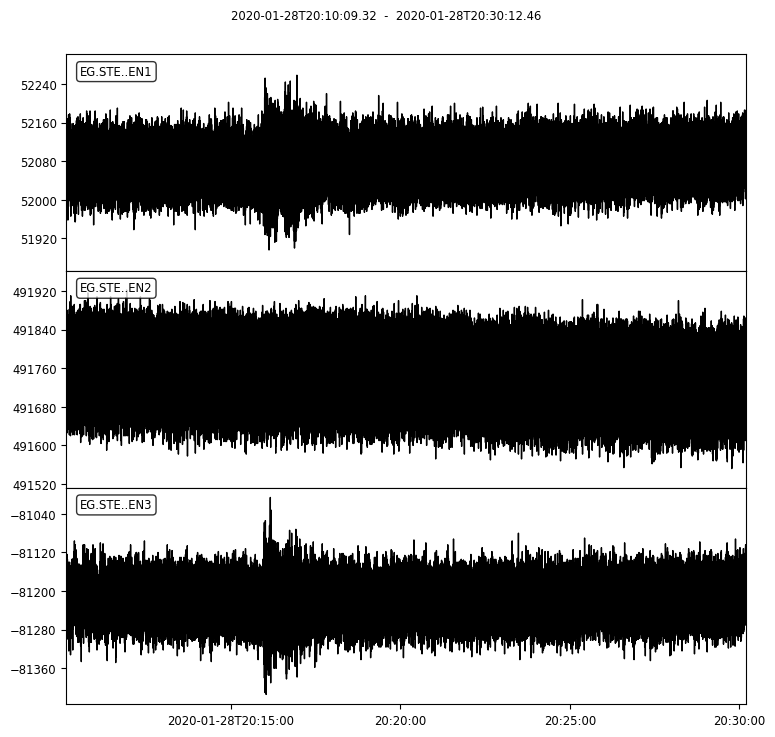

3 Trace(s) in Stream:
HL.KZN..HHN | 2020-01-28T20:10:10.640000Z - 2020-01-28T20:30:14.080000Z | 100.0 Hz, 120345 samples
HL.KZN..HHE | 2020-01-28T20:10:07.330000Z - 2020-01-28T20:30:11.400000Z | 100.0 Hz, 120408 samples
HL.KZN..HHZ | 2020-01-28T20:10:08.750000Z - 2020-01-28T20:30:13.330000Z | 100.0 Hz, 120459 samples


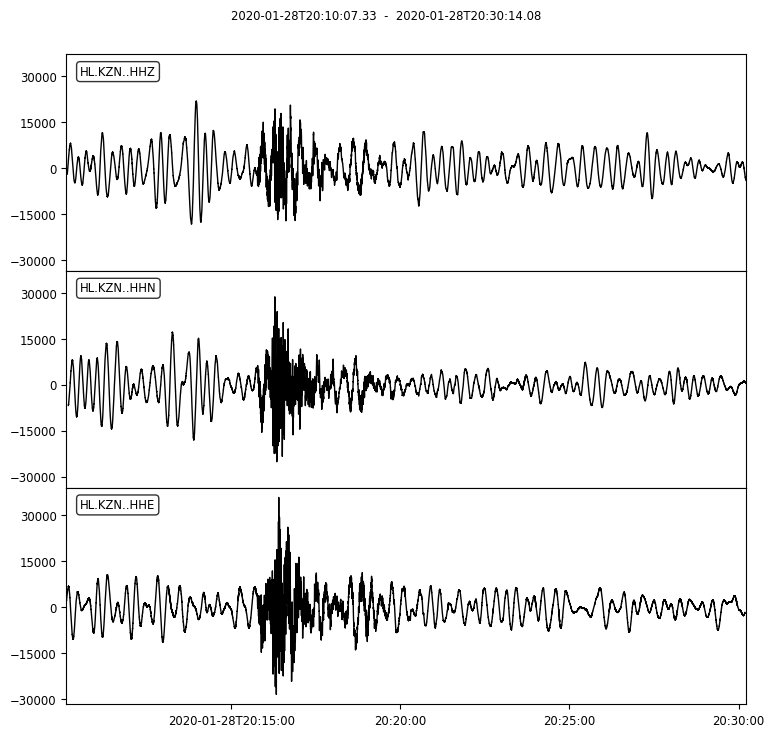

3 Trace(s) in Stream:
HL.PENT..HHE | 2020-01-28T20:10:07.390000Z - 2020-01-28T20:30:10.890000Z | 100.0 Hz, 120351 samples
HL.PENT..HHN | 2020-01-28T20:10:09.190000Z - 2020-01-28T20:30:11.050000Z | 100.0 Hz, 120187 samples
HL.PENT..HHZ | 2020-01-28T20:10:09.700000Z - 2020-01-28T20:30:12.650000Z | 100.0 Hz, 120296 samples


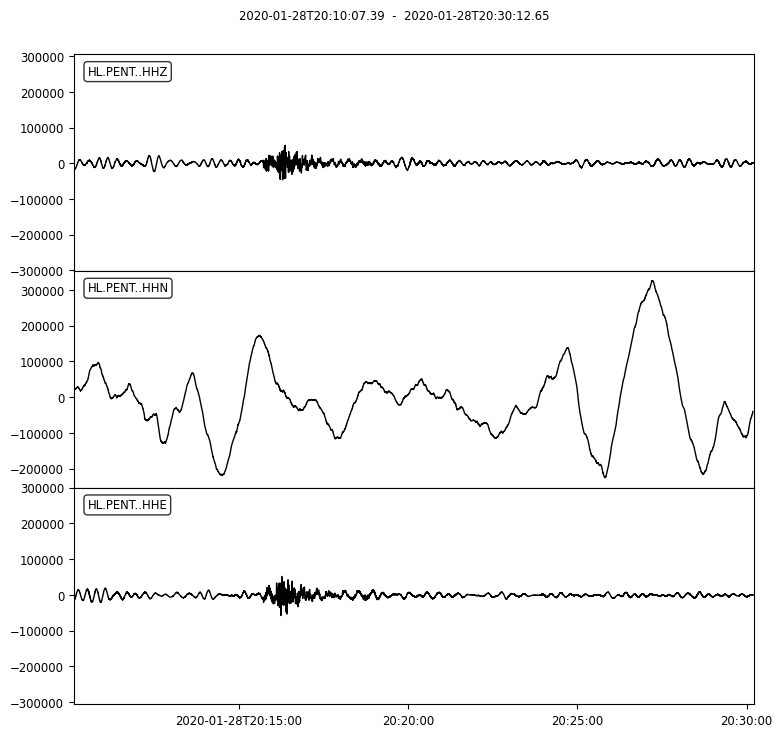

6 Trace(s) in Stream:
HL.PLG..HNZ | 2020-01-28T20:10:08.590000Z - 2020-01-28T20:30:12.650000Z | 100.0 Hz, 120407 samples
HL.PLG..HHN | 2020-01-28T20:10:10.430000Z - 2020-01-28T20:30:13.130000Z | 100.0 Hz, 120271 samples
HL.PLG..HNN | 2020-01-28T20:10:08.590000Z - 2020-01-28T20:30:12.650000Z | 100.0 Hz, 120407 samples
HL.PLG..HNE | 2020-01-28T20:10:08.590000Z - 2020-01-28T20:30:12.650000Z | 100.0 Hz, 120407 samples
HL.PLG..HHE | 2020-01-28T20:10:08.630000Z - 2020-01-28T20:30:12.350000Z | 100.0 Hz, 120373 samples
HL.PLG..HHZ | 2020-01-28T20:10:09.060000Z - 2020-01-28T20:30:13.890000Z | 100.0 Hz, 120484 samples


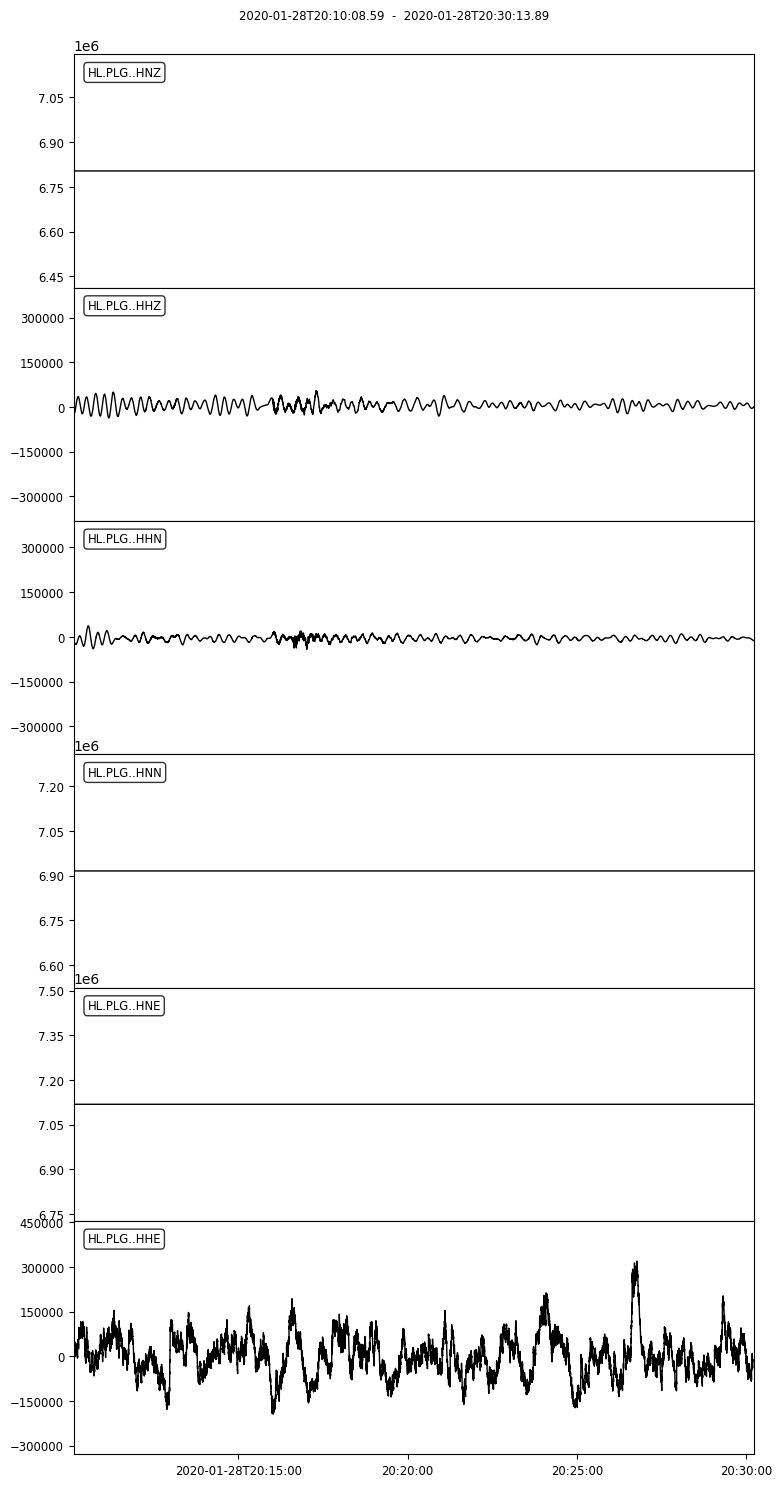

3 Trace(s) in Stream:
HT.GRG..HHE | 2020-01-28T20:10:09.600000Z - 2020-01-28T20:30:12.710000Z | 100.0 Hz, 120312 samples
HT.GRG..HHZ | 2020-01-28T20:10:06.880000Z - 2020-01-28T20:30:11.210000Z | 100.0 Hz, 120434 samples
HT.GRG..HHN | 2020-01-28T20:10:10.320000Z - 2020-01-28T20:30:11.810000Z | 100.0 Hz, 120150 samples


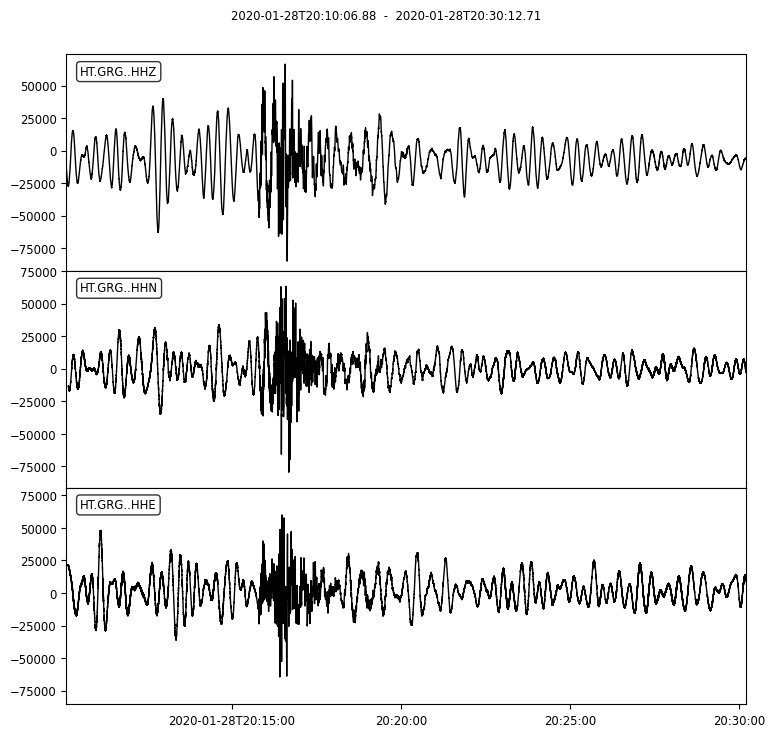

3 Trace(s) in Stream:
HT.KNT..HHE | 2020-01-28T20:10:10.600000Z - 2020-01-28T20:30:12.730000Z | 100.0 Hz, 120214 samples
HT.KNT..HHZ | 2020-01-28T20:10:10.530000Z - 2020-01-28T20:30:12.380000Z | 100.0 Hz, 120186 samples
HT.KNT..HHN | 2020-01-28T20:10:09.640000Z - 2020-01-28T20:30:13.430000Z | 100.0 Hz, 120380 samples


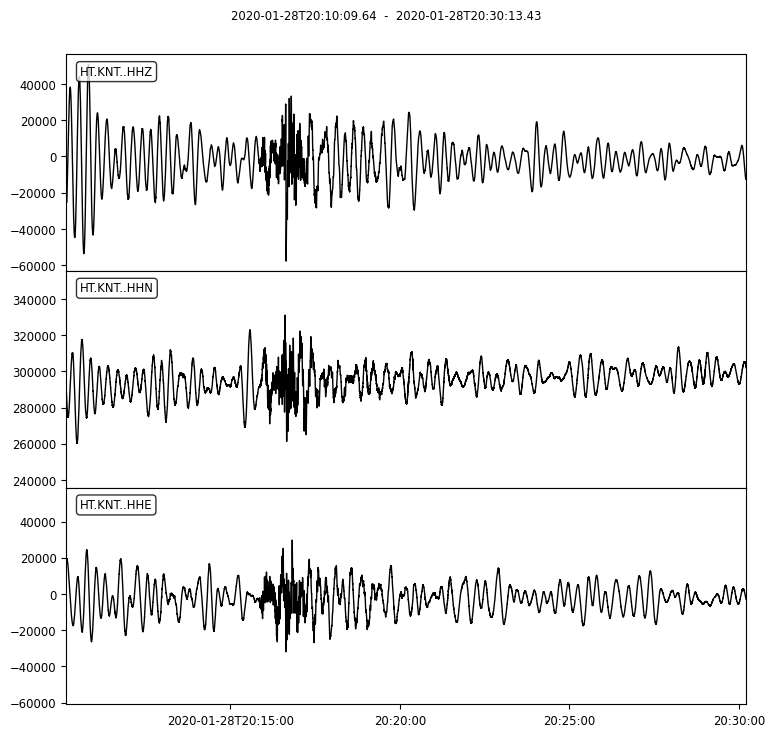

3 Trace(s) in Stream:
HT.LIT..HHE | 2020-01-28T20:10:08.180000Z - 2020-01-28T20:30:11.850000Z | 100.0 Hz, 120368 samples
HT.LIT..HHZ | 2020-01-28T20:10:08.060000Z - 2020-01-28T20:30:11.810000Z | 100.0 Hz, 120376 samples
HT.LIT..HHN | 2020-01-28T20:10:07.970000Z - 2020-01-28T20:30:10.880000Z | 100.0 Hz, 120292 samples


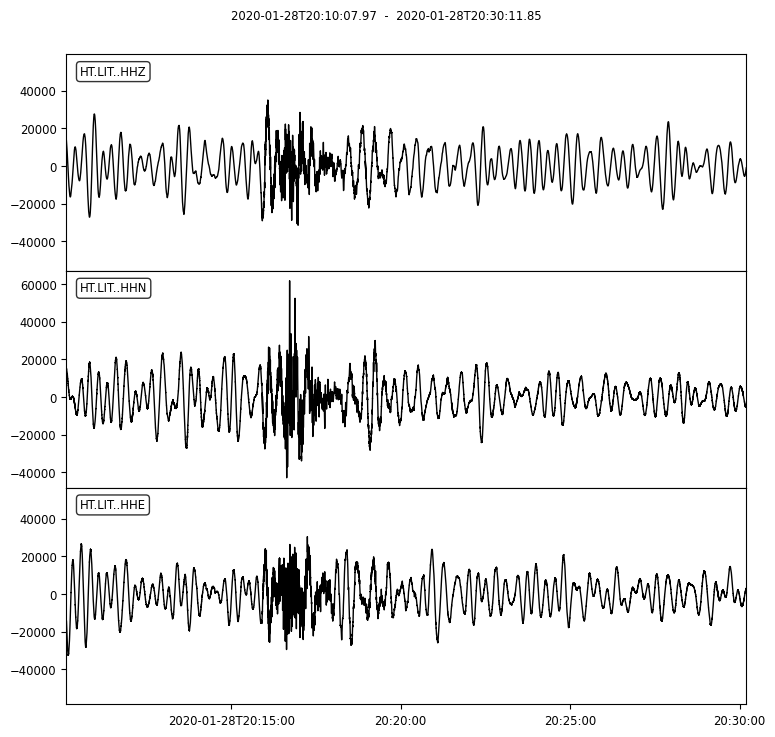

3 Trace(s) in Stream:
HT.NEST..HHE | 2020-01-28T20:10:08.020000Z - 2020-01-28T20:30:14.470000Z | 100.0 Hz, 120646 samples
HT.NEST..HHN | 2020-01-28T20:10:08.320000Z - 2020-01-28T20:30:11.050000Z | 100.0 Hz, 120274 samples
HT.NEST..HHZ | 2020-01-28T20:10:07.010000Z - 2020-01-28T20:30:12.120000Z | 100.0 Hz, 120512 samples


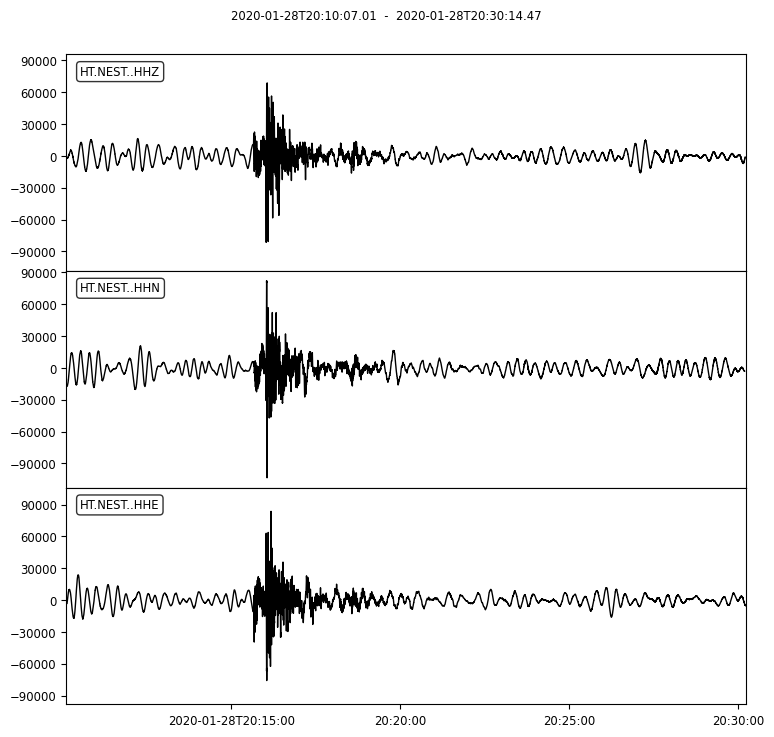

3 Trace(s) in Stream:
HT.OUR..HHN | 2020-01-28T20:10:08.480000Z - 2020-01-28T20:30:13.550000Z | 100.0 Hz, 120508 samples
HT.OUR..HHZ | 2020-01-28T20:10:09.740000Z - 2020-01-28T20:30:13.230000Z | 100.0 Hz, 120350 samples
HT.OUR..HHE | 2020-01-28T20:10:09.000000Z - 2020-01-28T20:30:14.670000Z | 100.0 Hz, 120568 samples


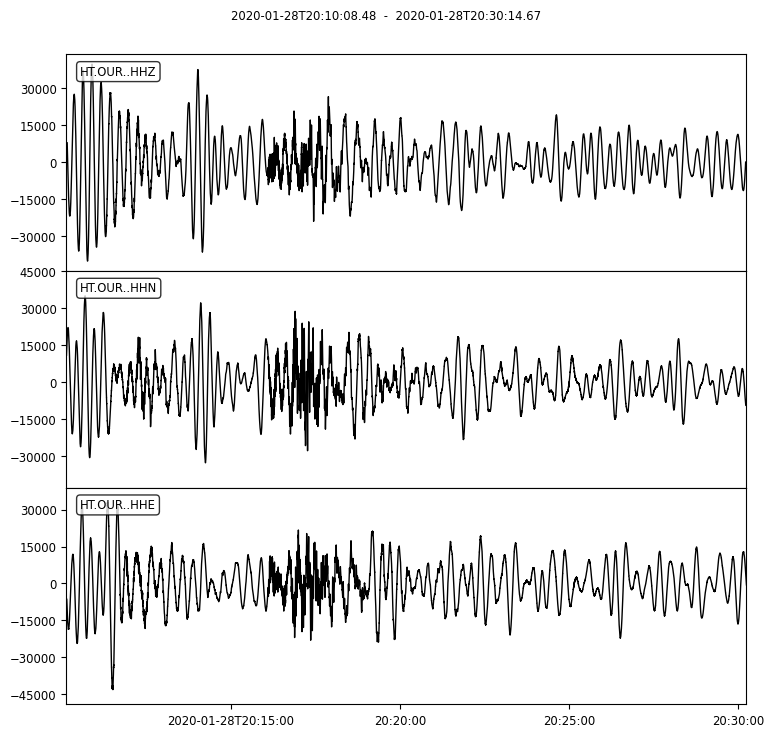

3 Trace(s) in Stream:
HT.SOH..HHZ | 2020-01-28T20:10:07.380000Z - 2020-01-28T20:30:10.930000Z | 100.0 Hz, 120356 samples
HT.SOH..HHE | 2020-01-28T20:10:08.900000Z - 2020-01-28T20:30:10.910000Z | 100.0 Hz, 120202 samples
HT.SOH..HHN | 2020-01-28T20:10:07.760000Z - 2020-01-28T20:30:13.430000Z | 100.0 Hz, 120568 samples


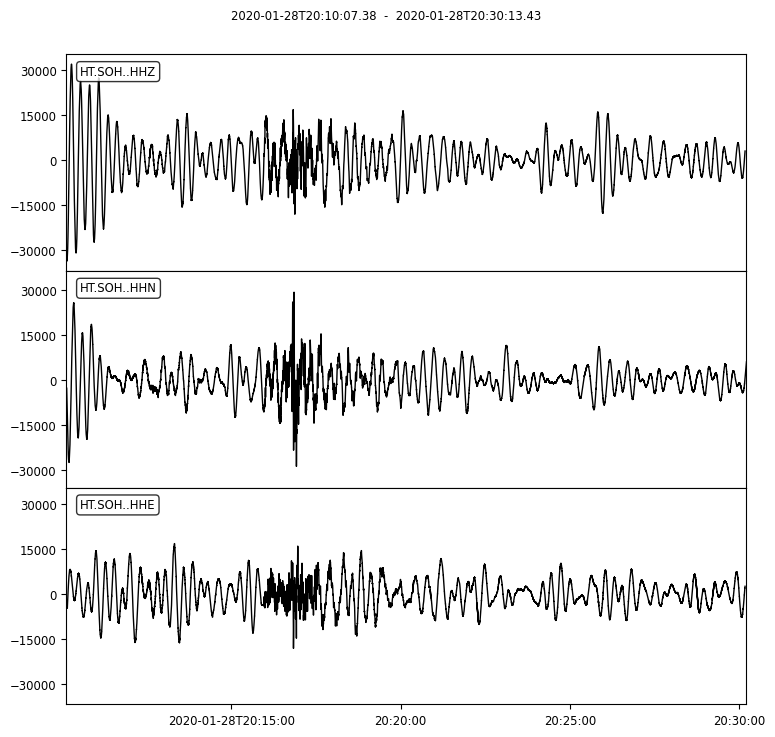

3 Trace(s) in Stream:
HT.THAS..HHE | 2020-01-28T20:10:09.010000Z - 2020-01-28T20:30:11.100000Z | 100.0 Hz, 120210 samples
HT.THAS..HHZ | 2020-01-28T20:10:08.820000Z - 2020-01-28T20:30:11.510000Z | 100.0 Hz, 120270 samples
HT.THAS..HHN | 2020-01-28T20:10:08.560000Z - 2020-01-28T20:30:13.070000Z | 100.0 Hz, 120452 samples


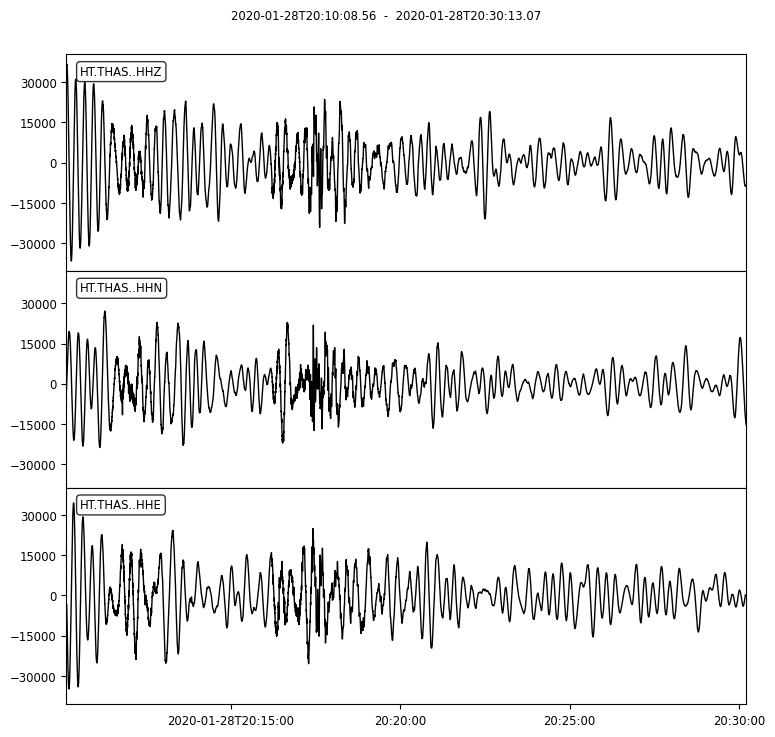

3 Trace(s) in Stream:
HT.THE..HHE | 2020-01-28T20:10:08.850000Z - 2020-01-28T20:30:13.280000Z | 100.0 Hz, 120444 samples
HT.THE..HHN | 2020-01-28T20:10:08.740000Z - 2020-01-28T20:30:11.090000Z | 100.0 Hz, 120236 samples
HT.THE..HHZ | 2020-01-28T20:10:08.890000Z - 2020-01-28T20:30:10.880000Z | 100.0 Hz, 120200 samples


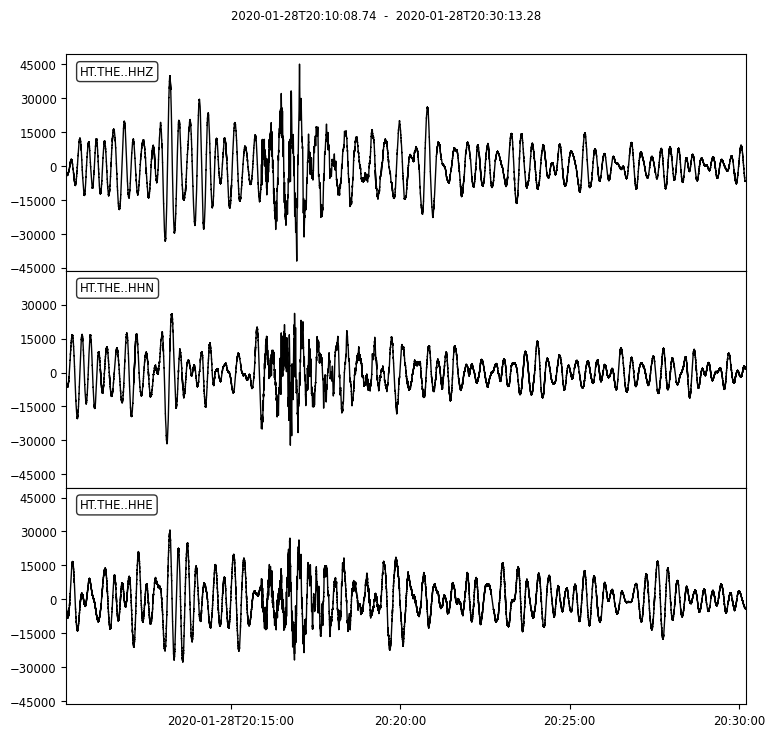

In [5]:
from obspy import read

# Loop through our validated stations, build URL, retrieve and read the data
for s in verified_stations:
    dataselect_url = (
        f"http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?"
        f"start={dt_start.isoformat()}&end={dt_end.isoformat()}&"
        f"network={s[0]}&station={s[1]}"
    )
    st = read(dataselect_url)
    
    # Print simple waveform metadata and plot the waveforms
    print(st)
    st.plot()

# 5. Quality tools on the orfeus-eu.org
Overview of the EIDA Quality Tools: https://www.orfeus-eu.org/data/eida/quality/

## Availability
Availability information can be easily previewed using web tool accessible via https://www.orfeus-eu.org/data/eida/quality/availability/:
![](img/availability.png)

## Data Quality Inspector
Data quality inspector rendering advanced waveform metrics is avaiable via https://www.orfeus-eu.org/data/eida/quality/metrics/.

Following statistical parameters can be selected and rendered:
* Quadratic mean
* Standard deviation
* Minimum
* Maximum
* Availability
* Gaps
* Sum of gaps
* Overlaps
* Sum of overlaps
* Median
* Mean
* Lower quartile
* Upper quartile

![](img/inspector.png)